In [1]:
#importing libraries
import pandas as pd
import sqlite3
import matplotlib
import seaborn

In [2]:
#configuring mysql into jupyter
%load_ext sql
%config SqlMagic.autopandas=True

In [2]:
#converting the statement PDF file to a data frame
import tabula

#path to the PDF file
pdf_path = "/home/muregz/data_analysis/mpesa_statement_analysis/mpesa_statement.pdf"

# password to unlock the PDF file
password = "900365"

# options for the PDF extraction
options = {
    "pages": "all",        # Extracting data from all the pages
    "password": password   # password to unlock the PDF
}

# read tables from a PDF file and save them as CSV files
#tabula.convert_into('/home/muregz/data_analysis/mpesa_statement_analysis/mpesa_statement.pdf', 'mpesa_statement.csv', output_format='csv', **options)

#had initially converted to a csv file
#changed it to an excel file to load the data better into a database table
#.ods is the same as .xlsx

df = pd.read_excel('/home/muregz/data_analysis/mpesa_statement_analysis/mpesa_statement.ods')

#dropping the unnamed column
#df = df.drop('Unnamed', axis=1)

# Print the extracted data
print(df)


                      Receipt No.  \
0                      REF8MUC88I   
1                      REF8MUC88I   
2                      REF9MU2IWF   
3                      REF9MU2IWF   
4                      REF7MT5G7N   
...                           ...   
3985                   QEG03RDEQM   
3986                   QEG23RDHRU   
3987  Statement Verification Code   
3988                          NaN   
3989                     KZ3FXNRZ   

                                        Completion Time  \
0                                   2023-05-15 20:19:22   
1                                   2023-05-15 20:19:22   
2                                   2023-05-15 20:17:21   
3                                   2023-05-15 20:17:21   
4                                   2023-05-15 20:10:35   
...                                                 ...   
3985                                2022-05-16 12:52:30   
3986                                2022-05-16 12:52:29   
3987  To verify the vali

In [4]:
#creating a local database to store the data
conn = sqlite3.connect('mpesa_statement_database')
c = conn.cursor()

c.execute('''CREATE TABLE IF NOT EXISTS mpesa (
    `Receipt No.` VARCHAR,
    `Completion Time` DATETIME,
    Details VARCHAR,
    `Transaction Status` VARCHAR,
    `Paid In` INT,
    Withdrawn INT,
    Balance INT
)
''')
conn.commit()

In [5]:
df.to_sql('mpesa', conn, if_exists='replace', index = False)

3990

In [6]:
import os
from sqlalchemy import create_engine
# Construct the connection URL
db_url = f"sqlite:///{os.path.abspath('/home/muregz/data_analysis/mpesa_statement_analysis/mpesa_statement_database')}"

# Set the DATABASE_URL environment variable
os.environ['DATABASE_URL'] = db_url

# Create a database engine
engine = create_engine(os.environ['DATABASE_URL'])

In [7]:
%%sql
SELECT * FROM mpesa;

Done.


,Receipt No.,Completion Time,Details,Transaction Status,Paid In,Withdrawn,Balance
0,REF8MUC88I,2023-05-15 20:19:22,Customer Transfer Fuliza MPesato - 07******212...,Completed,None,-50,0
1,REF8MUC88I,2023-05-15 20:19:22,OverDraft of Credit Party,Completed,50,None,50
2,REF9MU2IWF,2023-05-15 20:17:21,Merchant Payment Fuliza M-Pesato 7384394 - DAM...,Completed,None,-30,0
3,REF9MU2IWF,2023-05-15 20:17:21,OverDraft of Credit Party,Completed,30,None,30
4,REF7MT5G7N,2023-05-15 20:10:35,Customer Transfer Fuliza MPesato - 2547******5...,Completed,None,-10,0
...,...,...,...,...,...,...,...
3985,QEG03RDEQM,2022-05-16 12:52:30,OD Loan Repayment to 232323 -M-PESA Overdraw,Completed,None,-480.37,569.63
3986,QEG23RDHRU,2022-05-16 12:52:29,Funds received from -07******245 daniel njeri,Completed,1050,None,1050
3987,Statement Verification Code,To verify the validity of this M-PESA statemen...,None,None,None,None,None
3988,None,None,None,None,None,None,None


In [8]:
df.head(10)

,Receipt No.,Completion Time,Details,Transaction Status,Paid In,Withdrawn,Balance
0,REF8MUC88I,2023-05-15 20:19:22,Customer Transfer Fuliza MPesato - 07******212...,Completed,NaN,-50,0
1,REF8MUC88I,2023-05-15 20:19:22,OverDraft of Credit Party,Completed,50,NaN,50
2,REF9MU2IWF,2023-05-15 20:17:21,Merchant Payment Fuliza M-Pesato 7384394 - DAM...,Completed,NaN,-30,0
3,REF9MU2IWF,2023-05-15 20:17:21,OverDraft of Credit Party,Completed,30,NaN,30
4,REF7MT5G7N,2023-05-15 20:10:35,Customer Transfer Fuliza MPesato - 2547******5...,Completed,NaN,-10,0
5,REF7MT5G7N,2023-05-15 20:10:35,OverDraft of Credit Party,Completed,10,NaN,10
6,REF6MSH7KM,2023-05-15 20:05:47,Merchant Payment Fuliza M-Pesato 671957 - FISH...,Completed,NaN,-70,0
7,REF6MSH7KM,2023-05-15 20:05:47,OverDraft of Credit Party,Completed,70,NaN,70
8,REF5MQQC5T,2023-05-15 19:53:32,OD Loan Repayment to 232323 -M-PESA Overdraw,Completed,NaN,-150,0
9,REF0MQQ2C2,2023-05-15 19:53:32,Funds received from -07******440 diana mugwe,Completed,150,NaN,150


**Showing the number of times i used fuliza in the past year**

In [9]:
%%sql
SELECT COUNT(Details) AS `Number of Times used Fuliza`, SUM(ABS(`Paid In`)) AS `Total Amount Used`
FROM mpesa WHERE Details
LIKE '%Overdraft%';

 * sqlite:////home/muregz/data_analysis/mpesa_statement_analysis/mpesa_statement_database
Done.


,Number of Times used Fuliza,Total Amount Used
0,924,68083.82


In [10]:
df = df.dropna(subset=['Details', 'Paid In'])
total = df.loc[df['Details'].str.contains('overdraft', case=False), 'Paid In'].sum()

print(total)


68083.81999999999


**showing the number of times fuliza was used to pay for alcohol**

In [11]:
%%sql
SELECT COUNT(Details) AS 'Number of times',
SUM(ABS(Withdrawn)) AS `Total amount used`
FROM mpesa WHERE Details
LIKE '%Fuliza%' AND Details LIKE '%WINES%' OR Details LIKE '%Onsare%' OR Details LIKE '%Bar%';

 * sqlite:////home/muregz/data_analysis/mpesa_statement_analysis/mpesa_statement_database
Done.


,Number of times,Total amount used
0,88,26226.0


In [12]:
%%sql
SELECT COUNT(Details), SUM(ABS(Withdrawn)) AS 'Total amount used to pay for alcohol'
FROM mpesa
WHERE Details LIKE '%Wines%' OR Details LIKE '%SIMBA' OR Details LIKE '%PUB';

 * sqlite:////home/muregz/data_analysis/mpesa_statement_analysis/mpesa_statement_database
Done.


,COUNT(Details),Total amount used to pay for alcohol
0,90,37389.0


**Showing total amount spent on alcohol**

In [4]:
pombe = df.dropna(subset=['Details', 'Withdrawn'])
s = ['Wines', 'Onsare', 'Bar', 'Pub', 'Simba', 'Tamasha']
v = pombe['Details'].str.contains('|'.join(s), case=False)
total_amount = [pombe.loc[v, 'Withdrawn'].sum(), pombe.loc[v, 'Withdrawn'].count()]
absolute_values = [abs(value) for value in total_amount]
print(absolute_values)


[45220, 132]


**Showing the total amount used to repay Fuliza**

In [14]:
%%sql
SELECT SUM(ABS(Withdrawn)) AS `Amount used to repay fuliza loan`
FROM mpesa WHERE Details
LIKE '%Fuliza%';

 * sqlite:////home/muregz/data_analysis/mpesa_statement_analysis/mpesa_statement_database
Done.


,Amount used to repay fuliza loan
0,104549.0


In [5]:
df = df.dropna(subset=['Details', 'Withdrawn'])
fuliza_loan = df['Details'].str.contains('Fuliza')
repaid = [df.loc[fuliza_loan, 'Withdrawn'].sum()]
repaid_absolute = [abs(value) for value in repaid]
print(repaid_absolute)

[104549]


**Showing amount used to buy airtime**

In [16]:
%%sql
SELECT SUM(ABS(Withdrawn)) AS `Total amount used`
FROM mpesa WHERE Details
LIKE '%Airtime%';

 * sqlite:////home/muregz/data_analysis/mpesa_statement_analysis/mpesa_statement_database
Done.


,Total amount used
0,3318.0


In [35]:
airtime = df['Details'].str.contains("Airtime")
airtime_amount = [df.loc[airtime, 'Withdrawn'].sum()]
airtime_absolute = [abs(value) for value in airtime_amount]
print(airtime_absolute)

[3318]


# showing amount used to pay for electricity

In [40]:
tokens = df['Details'].str.contains('KPLC')
tokens_amount = [df.loc[tokens, 'Withdrawn'].sum()]
tokens_absolute = [abs(value) for value in tokens_amount]
print(tokens_absolute)

[614]


**amount used to pay rent**

In [13]:
rent = ['Mbuvi', 'Cosmic', 'Pay Bill to 247247 - Equity Paybill Account Acc.0300196339189']
rent_amount = df['Details'].str.contains('|'.join(rent), case=False)
total_rent = [df.loc[rent_amount, 'Withdrawn'].sum()]
rent_absolute = [abs(value) for value in total_rent]
print(rent_absolute)

[43600]


**Amount used to buy recreational drugs**

In [18]:
%%sql
SELECT SUM(ABS(Withdrawn)) AS `Total Amount Used`
FROM mpesa
WHERE Details LIKE '%Ian Maina%' OR Details LIKE '%Muganda%' OR Details LIKE '%Wambwa%'; -- Hiding the names you know why

 * sqlite:////home/muregz/data_analysis/mpesa_statement_analysis/mpesa_statement_database
Done.


,Total Amount Used
0,10525.0


In [33]:
recreational = ['Ian Maina', 'Muganda', 'Wambwa']
drugs = df['Details'].str.contains('|'.join(recreational), case=False)
recreational_drugs = [df.loc[drugs, 'Withdrawn'].sum()]
recreational_absolute = [abs(value) for value in recreational_drugs]
print(recreational_absolute)


[10525]


**Showing total amount received**

In [20]:
%%sql
SELECT SUM(`Paid In`) AS `Total Amount Received`
FROM mpesa
WHERE Details LIKE '%Funds received%' OR Details LIKE '%International Transfer%';

 * sqlite:////home/muregz/data_analysis/mpesa_statement_analysis/mpesa_statement_database
Done.


,Total Amount Received
0,223348


**Showing total amount used**

In [22]:
%%sql
SELECT SUM(ABS(Withdrawn)) AS `Total amount used`
FROM mpesa;

 * sqlite:////home/muregz/data_analysis/mpesa_statement_analysis/mpesa_statement_database
Done.


,Total amount used
0,468381.71


$$
VISUALIZATION
$$

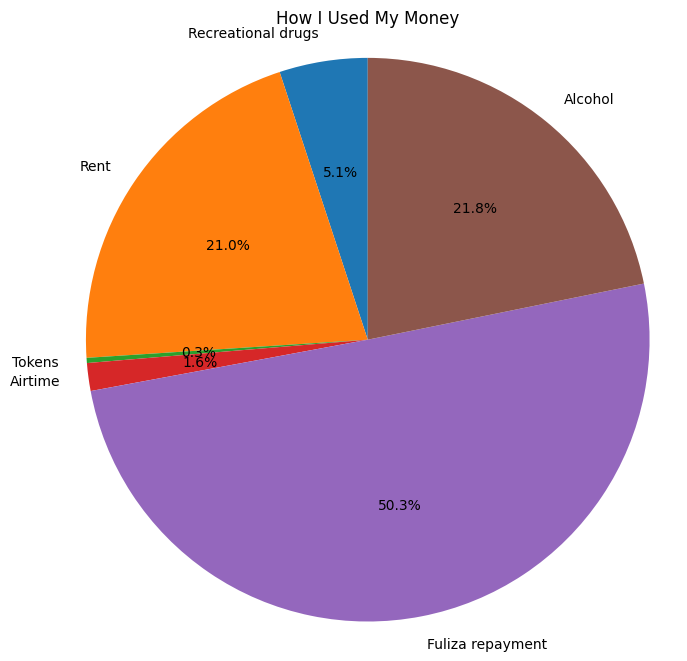

In [41]:
import matplotlib.pyplot as plt
import numpy as np

subset = [recreational_absolute, rent_absolute, tokens_absolute, airtime_absolute, repaid_absolute, absolute_values]

# Calculate the sum of the values within each array
subset_sums = [np.sum(arr) for arr in subset]

# Calculate the total sum of all subsets
total_subset = np.sum(subset_sums)

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(subset_sums, labels=['Recreational drugs', 'Rent', 'Tokens', 'Airtime', 'Fuliza repayment', 'Alcohol'], autopct='%1.1f%%', startangle=90)
plt.title('How I Used My Money')
plt.axis('equal')

# Show the pie chart
plt.show()
